In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
auth.authenticate_user()

In [ ]:
import pandas as pd
from google.cloud import bigquery
import os
import google.auth

# Method 1: Direct setup without checks
project_id = 'corded-vim-431009-f4'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

def setup_bigquery():
    credentials, project = google.auth.default()
    return bigquery.Client(credentials=credentials, project=project)

try:
    # Test connection
    client = setup_bigquery()

    # Define query function
    def run_query(query):
        return client.query(query).to_dataframe()

    # Corrected query for PhysioNet data
    test_query = """
    SELECT *
    FROM physionet-data.mimiciv_hosp.patients
    LIMIT 5
    """

    result = run_query(test_query)
    print("Connection successful!")
    print(result)

except Exception as e:
    print(f"Error type: {type(e)}")
    print(f"Error details: {str(e)}")

Error type: <class 'google.api_core.exceptions.Forbidden'>
Error details: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/corded-vim-431009-f4/jobs?prettyPrint=false: Access Denied: Project corded-vim-431009-f4: User does not have bigquery.jobs.create permission in project corded-vim-431009-f4.

Location: None
Job ID: b67731bd-59ee-4f00-9291-7ac394aa20e5



# ICD Codes

ICD 10 Codes:

*   I50* : All I50 codes are relating to heart failure, found here: https://www.icd10data.com/ICD10CM/Codes/I00-I99/I30-I5A/I50-


ICD 9 Codes:

*   428* : All ICD9 codes for heart failure found here: https://pmc.ncbi.nlm.nih.gov/articles/PMC7153053/table/t1-3201850/









In [ ]:
# Define the query for heart failure patients
query_hf_icd = """
SELECT subject_id, hadm_id, icd_code, icd_version
FROM `physionet-data.mimic_hosp.diagnoses_icd`
WHERE (
  (icd_version = 10 AND icd_code IN ('I50', 'I501', 'I5020', 'I5021', 'I5022', 'I5023', 'I5030', 'I5031', 'I5032', 'I5033', 'I5040', 'I5041', 'I5042', 'I5043', 'I5081', 'I50810', 'I50811', 'I50812', 'I50813', 'I50814', 'I5082', 'I5083', 'I5084', 'I5089', 'I509'))
  OR
  (icd_version = 9 AND icd_code IN ('4280', '4281', '42820', '42821', '42822', '42823', '42830', '42831', '42832', '42833', '42840', '42841', '42842', '42843', '4289'))
)
"""



# Execute the query and load the result into a DataFrame
df_hf_icd = client.query(query_hf_icd).to_dataframe()

# Sort by 'icd_version' to prioritize ICD-10 (version 10) over ICD-9 (version 9)
df_hf_icd.sort_values(by='icd_version', ascending=False, inplace=True)

# Drop duplicates based on 'hadm_id', keeping the first occurrence (which will be ICD-10 if available)
df_hf_icd.drop_duplicates(subset='hadm_id', keep='first', inplace=True)

# remove index
df_hf_icd.reset_index(drop=True, inplace=True)

df_hf_icd.drop(columns="icd_version", inplace=True)
# Display the results
display(len(df_hf_icd))

display(df_hf_icd.head())


Forbidden: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/physionet-data-432607/jobs?prettyPrint=false: Access Denied: Project physionet-data-432607: User does not have bigquery.jobs.create permission in project physionet-data-432607.

Location: None
Job ID: 36261f9b-30a1-4d27-80e9-a52b3f8ac085


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define the query for heart failure patients
query_code_first_hf_icd = """
SELECT subject_id, hadm_id, icd_code, icd_version
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE icd_code IN ('O008', 'I110', 'I130', 'I131', 'I9713', 'O754', 'I0981')
AND icd_version = 10;
"""


# Execute the query and load the result into a DataFrame
df_hf_icd = client.query(query_hf_icd).to_dataframe()

# Display the results
display(len(df_hf_icd))

In [ ]:
# Query to find ejection fraction in the d_items table
query_find_ef_itemid = """
SELECT itemid, label
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) LIKE '%ejection fraction%';
"""

df_ef_itemid = client.query(query_find_ef_itemid).to_dataframe()

# Display the itemid for ejection fraction
display(df_ef_itemid)

In [ ]:
# Query to extract ejection fraction (EF) values from chartevents
query_ef_values = """
SELECT subject_id, hadm_id, charttime, value AS ejection_fraction
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 227008
AND value IS NOT NULL
ORDER BY subject_id, charttime;
"""

# Execute the query and load the result into a DataFrame
df_ef_values = client.query(query_ef_values).to_dataframe()

# Display the first few rows of ejection fraction data
display(df_ef_values.head())

In [ ]:
# Query to check for cardiac markers that might include ejection fraction
query_cardiac_marker = """
SELECT *
FROM `physionet-data.mimiciv_derived.cardiac_marker`
LIMIT 10;
"""

df_cardiac_marker = client.query(query_cardiac_marker).to_dataframe()
display(df_cardiac_marker.head())

In [ ]:
# Query to check for first day lab results that might include ejection fraction
query_first_day_lab = """
SELECT *
FROM `physionet-data.mimiciv_derived.first_day_lab`
LIMIT 10;
"""

df_first_day_lab = client.query(query_first_day_lab).to_dataframe()
display(df_first_day_lab.head())

# Cholesterol

In [ ]:
# Query to find cholesterol item IDs
query_cholesterol_itemid = """
SELECT itemid, label
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE LOWER(label) LIKE '%cholesterol%';
"""

df_cholesterol_itemid = client.query(query_cholesterol_itemid).to_dataframe()
display(df_cholesterol_itemid)

In [ ]:
# Query to extract cholesterol values (HDL, LDL, Total)
query_cholesterol_values = """
SELECT subject_id, hadm_id, charttime,
       CASE WHEN itemid = 50907 THEN value END AS total_cholesterol,
       CASE WHEN itemid = 50905 THEN value END AS ldl_cholesterol,
       CASE WHEN itemid = 50904 THEN value END AS hdl_cholesterol
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid IN (50907, 50905, 50904)  -- Total, LDL, HDL cholesterol
AND value IS NOT NULL
ORDER BY subject_id, charttime;
"""

# Execute the query and load the result into a DataFrame
df_cholesterol = client.query(query_cholesterol_values).to_dataframe()

# Drop missing values and aggregate
df_cholesterol['total_cholesterol'] = pd.to_numeric(df_cholesterol['total_cholesterol'], errors='coerce')
df_cholesterol['ldl_cholesterol'] = pd.to_numeric(df_cholesterol['ldl_cholesterol'], errors='coerce')
df_cholesterol['hdl_cholesterol'] = pd.to_numeric(df_cholesterol['hdl_cholesterol'], errors='coerce')

# Group by subject_id and hadm_id to calculate the average cholesterol levels
df_avg_cholesterol = df_cholesterol.groupby(['subject_id', 'hadm_id']).agg({
    'total_cholesterol': 'mean',
    'ldl_cholesterol': 'mean',
    'hdl_cholesterol': 'mean'
}).reset_index()

# Display the result
display(df_avg_cholesterol.head())

# Blood Pressure

In [ ]:
# Query to find blood pressure item IDs
query_bp_itemid = """
SELECT itemid, label
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) LIKE '%blood pressure%';
"""

df_bp_itemid = client.query(query_bp_itemid).to_dataframe()
display(df_bp_itemid)

In [ ]:
# Query to extract blood pressure values (systolic, diastolic, mean)
query_bp_values = """
SELECT subject_id, hadm_id, charttime,
       CASE WHEN itemid IN (220050, 220179, 224167, 227243) THEN value END AS systolic_bp,
       CASE WHEN itemid IN (220051, 220180, 224643, 227242) THEN value END AS diastolic_bp,
       CASE WHEN itemid IN (220052, 220181) THEN value END AS mean_bp
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid IN (220050, 220051, 220052, 220179, 220180, 220181,
                 224167, 224643, 227242, 227243)
AND value IS NOT NULL
ORDER BY subject_id, charttime;
"""

# Execute the query and load the result into a DataFrame
df_bp = client.query(query_bp_values).to_dataframe()

# Convert the values to numeric (in case any are stored as strings)
df_bp['systolic_bp'] = pd.to_numeric(df_bp['systolic_bp'], errors='coerce')
df_bp['diastolic_bp'] = pd.to_numeric(df_bp['diastolic_bp'], errors='coerce')
df_bp['mean_bp'] = pd.to_numeric(df_bp['mean_bp'], errors='coerce')

# Group by subject_id and hadm_id to calculate the average blood pressure values
df_avg_bp = df_bp.groupby(['subject_id', 'hadm_id']).agg({
    'systolic_bp': 'mean',
    'diastolic_bp': 'mean',
    'mean_bp': 'mean'
}).reset_index()

# Display the result
display(df_avg_bp.head())

# BNP and NTPROBNP

- Below is digital phenotyping for BNP and Nt Pro BNP

In [ ]:
# project id for Kelan's big query
project_id = 'mlah-431805'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

client = bigquery.Client()

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# Set the dataset
dataset = 'mimiciv'

In [ ]:
# Finds BNP item id, for finding relevant chartevents

query_find_BNP_itemid = """
SELECT itemid, label
FROM `physionet-data.mimic_icu.d_items`
WHERE LOWER(label) LIKE '%bnp%'
"""

df_BNP_itemid = client.query(query_find_BNP_itemid).to_dataframe()

# Display the itemid for bnp
display(df_BNP_itemid)

# Item id BNP == 227446

In [ ]:
"""
Query to retrieve all BNP readings, column headings inlcude: subject_id, hadm_id, charttime, and bnp - already verfied UOM is pg/mL
"""
query_bnp_readings = """
SELECT subject_id, hadm_id, charttime, value AS BNP
FROM `physionet-data.mimic_icu.chartevents`
WHERE itemid = 227446
"""

df_bnp_readings = client.query(query_bnp_readings).to_dataframe()

df_bnp_readings = df_bnp_readings.dropna()
df_bnp_readings['BNP'] = df_bnp_readings['BNP'].astype(float)
df_bnp_readings = df_bnp_readings.drop(columns=['charttime'])
df_avg_bnp = df_bnp_readings.groupby(['subject_id','hadm_id']).agg({
    'BNP': 'mean'
})

# Rename the column to reflect it's an average
df_avg_bnp.rename(columns={'BNP': 'avg_BNP'}, inplace=True)

# Display the result
display(df_avg_bnp.head())


In [ ]:
"""
Query to retrieve all nt pro BNP readings, column headings inlcude: subject_id, hadm_id, charttime, and ntprobnp.
"""
query_cardiac_marker = """
SELECT *
FROM `physionet-data.mimic_derived.cardiac_marker`
"""

df_cardiac_marker = client.query(query_cardiac_marker).to_dataframe()
# Filter the DataFrame to retain rows where ntprobnp is not null
nt_pro_bnp_df = df_cardiac_marker[df_cardiac_marker['ntprobnp'].notna()]

# Select only the desired columns
nt_pro_bnp_df = nt_pro_bnp_df[['subject_id', 'hadm_id', 'charttime', 'ntprobnp']]

nt_pro_bnp_df = nt_pro_bnp_df.dropna()
nt_pro_bnp_df['ntprobnp'] = nt_pro_bnp_df['ntprobnp'].astype(float)
nt_pro_bnp_df = nt_pro_bnp_df.drop(columns=['charttime'])
avg_ntprobnp_df = nt_pro_bnp_df.groupby(['subject_id','hadm_id']).agg({
    'ntprobnp': 'mean'
})

# Rename the column to reflect it's an average
avg_ntprobnp_df.rename(columns={'ntprobnp': 'avg_ntproBNP'}, inplace=True)

# Display the result
display(avg_ntprobnp_df.head())



# Demographic

In [ ]:
# project id for Ajith's big query
from google.colab import auth
import pandas as pd
from google.cloud import bigquery

# Authenticate
auth.authenticate_user()
# Create a BigQuery client
client = bigquery.Client(project='corded-vim-431009-f4')

In [ ]:
query = """
WITH heart_failure_patients AS (
  SELECT subject_id, hadm_id, icd_code, icd_version,
         ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY hadm_id DESC) AS rn
  FROM physionet-data.mimiciv_hosp.diagnoses_icd
  WHERE icd_code IN ('4280', 'I50', '42821', 'I5020', 'I5042', 'I5014')
),
ef_values AS (
  SELECT subject_id, charttime, value AS ejection_fraction,
         ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY charttime DESC) AS rn
  FROM physionet-data.mimiciv_icu.chartevents
  WHERE itemid = 227008 -- Ejection Fraction
    AND value IS NOT NULL
),
bnp_values AS (
  SELECT
    le.subject_id,
    le.charttime,
    le.valuenum AS bnp,
    ROW_NUMBER() OVER (PARTITION BY le.subject_id ORDER BY le.charttime DESC) AS rn
  FROM physionet-data.mimiciv_hosp.labevents le
  JOIN physionet-data.mimiciv_hosp.d_labitems di ON le.itemid = di.itemid
  WHERE LOWER(di.label) LIKE '%bnp%' AND LOWER(di.label) NOT LIKE '%nt%'
  AND le.valuenum IS NOT NULL
),
nt_probnp_values AS (
  SELECT
    le.subject_id,
    le.charttime,
    le.valuenum AS nt_probnp,
    ROW_NUMBER() OVER (PARTITION BY le.subject_id ORDER BY le.charttime DESC) AS rn
  FROM physionet-data.mimiciv_hosp.labevents le
  JOIN physionet-data.mimiciv_hosp.d_labitems di ON le.itemid = di.itemid
  WHERE LOWER(di.label) LIKE '%nt%pro%bnp%'
  AND le.valuenum IS NOT NULL
),
troponin_values AS (
  SELECT
    le.subject_id,
    le.charttime,
    le.valuenum AS troponin,
    ROW_NUMBER() OVER (PARTITION BY le.subject_id ORDER BY le.charttime DESC) AS rn
  FROM physionet-data.mimiciv_hosp.labevents le
  JOIN physionet-data.mimiciv_hosp.d_labitems di ON le.itemid = di.itemid
  WHERE LOWER(di.label) LIKE '%troponin%'
  AND le.valuenum IS NOT NULL
),
patient_measurements AS (
  SELECT
    subject_id,
    AVG(CASE WHEN itemid = 226730 THEN valuenum END) AS height,
    AVG(CASE WHEN itemid = 226512 THEN valuenum END) AS weight,
    ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY charttime DESC) AS rn
  FROM physionet-data.mimiciv_icu.chartevents
  WHERE itemid IN (226730, 226512) -- Height and Weight
    AND valuenum IS NOT NULL
  GROUP BY subject_id, charttime
)

SELECT
  hf.subject_id,
  p.gender,
  p.anchor_age AS age,
  a.admission_type,
  a.admittime,
  ef.ejection_fraction,
  bnp.bnp,
  nt.nt_probnp,
  tr.troponin,
  pm.height,
  pm.weight
FROM heart_failure_patients hf
JOIN physionet-data.mimiciv_hosp.patients p ON hf.subject_id = p.subject_id
JOIN physionet-data.mimiciv_hosp.admissions a ON hf.hadm_id = a.hadm_id
LEFT JOIN ef_values ef ON hf.subject_id = ef.subject_id AND ef.rn = 1
LEFT JOIN bnp_values bnp ON hf.subject_id = bnp.subject_id AND bnp.rn = 1
LEFT JOIN nt_probnp_values nt ON hf.subject_id = nt.subject_id AND nt.rn = 1
LEFT JOIN troponin_values tr ON hf.subject_id = tr.subject_id AND tr.rn = 1
LEFT JOIN patient_measurements pm ON hf.subject_id = pm.subject_id AND pm.rn = 1
WHERE hf.rn = 1

ORDER BY hf.subject_id, a.admittime DESC
LIMIT 1000
"""

# Run the query and convert to a DataFrame
df = client.query(query).to_dataframe()

# Display the first few rows of the DataFrame
print(df.head())

In [ ]:
df['admittime'] = pd.to_datetime(df['admittime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df.isna().sum()

In [ ]:
import numpy as np
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['ejection_fraction'] = df['ejection_fraction'].replace('None', np.nan)
df['ejection_fraction'] = pd.to_numeric(df['ejection_fraction'], errors='coerce')
numeric_cols = ['bnp', 'nt_probnp', 'troponin']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df['gender'] = df['gender'].map({'M': 'M', 'F': 'F', 'MALE': 'M', 'FEMALE': 'F'})
df['admission_type'] = df['admission_type'].replace({'EW EMER.': 'EMERGENCY', 'EU OBSERVATION': 'OBSERVATION'})

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def clean_data(df):
    df['admittime'] = pd.to_datetime(df['admittime'])
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['height'] = pd.to_numeric(df['height'], errors='coerce')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

    numeric_cols = ['bnp', 'nt_probnp', 'troponin']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    df['gender'] = df['gender'].map({'M': 'M', 'F': 'F'})

    for col in numeric_cols + ['age', 'height', 'weight']:
        df[col].fillna(df[col].median(), inplace=True)

    df['gender'].fillna(df['gender'].mode()[0], inplace=True)
    df['admission_type'].fillna(df['admission_type'].mode()[0], inplace=True)

    df = df.drop(columns=['ejection_fraction'])

    return df

cleaned_df = clean_data(df)

print(cleaned_df.head())
print(cleaned_df.info())
print(cleaned_df.describe())
print(cleaned_df.isnull().sum())

In [ ]:
columns= ['subject_id', 'age', 'admission_type', 'height', 'weight']
filtered_df = df[columns]
print(filtered_df)

# Troponin

In [ ]:
# Find revelant items in ICU
df = run_query("""
SELECT *
FROM `physionet-data.mimic_icu.d_items`
WHERE LOWER(label) LIKE '%troponin%';
""")
df.head(10)

In [ ]:
# Troponin-T from mimiciv_icu.chartevents
query_icu_troponin_t = """
    SELECT subject_id, hadm_id, charttime, valuenum AS troponin_T_value
    FROM `physionet-data.mimiciv_icu.chartevents`
    WHERE itemid = 227429
    ORDER BY charttime;
"""
df_icu_troponin_t = run_query(query_icu_troponin_t)
df_icu_troponin_t.head(10)

In [ ]:
# Find revelant items in hosp
df = run_query("""
    SELECT *
    FROM `physionet-data.mimiciv_hosp.d_labitems`
    WHERE LOWER(label) LIKE '%troponin%';
""")
df.head(10)
# Fine 51002,52642 do not have a value

In [ ]:
# Troponin T from mimiciv_hosp.labevents
query_hosp_troponin_t = """
    SELECT subject_id, hadm_id, charttime, value AS troponin_T_value
    FROM `physionet-data.mimiciv_hosp.labevents`
    WHERE itemid = 51003
    ORDER BY charttime;
"""
df_hosp_troponin_t = run_query(query_hosp_troponin_t)
df_hosp_troponin_t.head(10)

In [ ]:
# Troponin from mimiciv_derived.cardiac_marker
query_derived_troponin = """
    SELECT subject_id, hadm_id, charttime, troponin_t AS troponin_T_value
    FROM `physionet-data.mimiciv_derived.cardiac_marker`
    WHERE troponin_t IS NOT NULL
    ORDER BY charttime;
"""
df_derived_troponin_t = run_query(query_derived_troponin)
df_derived_troponin_t.head(10)

In [ ]:
# Combine the dataframes vertically
combined_troponin_df = pd.concat([df_icu_troponin_t, df_hosp_troponin_t, df_derived_troponin_t], ignore_index=True)

# Sort by subject_id and charttime for easier analysis
combined_troponin_df = combined_troponin_df.sort_values(by=['subject_id', 'charttime']).reset_index(drop=True)

# Display the combined dataframe
print(combined_troponin_df)

In [ ]:
# Convert troponin_T_value to numeric, forcing invalid parsing to NaN
combined_troponin_df['troponin_T_value'] = pd.to_numeric(combined_troponin_df['troponin_T_value'], errors='coerce')

# Drop rows where troponin_T_value is NaN
combined_troponin_df = combined_troponin_df.dropna(subset=['troponin_T_value'])

# Now perform the groupby and aggregation
troponin_aggregated = combined_troponin_df.groupby(['subject_id', 'hadm_id']).agg({
    'troponin_T_value': 'mean'
}).reset_index()

# Renaming the aggregated column for clarity
troponin_aggregated.rename(columns={'troponin_T_value': 'avg_troponin_T_value'}, inplace=True)

# Display the aggregated DataFrame
print(troponin_aggregated)


This DataFrame provides the average troponin T reading for each patient during their hospital stay.
Each patient's troponin reading on each admission is aggregated to a mean value.

In [ ]:
# fetch admission type data
query_admission_type = """
SELECT subject_id, hadm_id, admission_type
FROM `physionet-data.mimiciv_hosp.admissions`
ORDER BY admittime;
"""

# Run the query to get the admissions data
df_admissions = run_query(query_admission_type)

# Now merge the admission type with the troponin aggregated data
troponin_with_admission_type = pd.merge(troponin_aggregated, df_admissions, on=['subject_id', 'hadm_id'], how='left')

# Display the merged DataFrame
print(troponin_with_admission_type.head())

Since I am not sure whether we want admission_type, if so this frame is combined with admission_type.

# Merged Dataframe

In [ ]:
# Merge avg_ntprobnp_df and troponin_with_admission_type on 'subject_id' and 'hadm_id'
first_merge = pd.merge(avg_ntprobnp_df, troponin_with_admission_type, on=['subject_id', 'hadm_id'], how='left')

# Merge first merge with filtered_df on 'subject_id'
second_merge = pd.merge(first_merge, filtered_df, on='subject_id', how='left')

# Merge second merge with cholesterol data (df_avg_cholesterol) on 'subject_id' and 'hadm_id'
third_merge = pd.merge(second_merge, df_avg_cholesterol, on=['subject_id', 'hadm_id'], how='left')

# Finally, merge with blood pressure data (df_avg_bp) on 'subject_id' and 'hadm_id'
final_merged_df = pd.merge(third_merge, df_avg_bp, on=['subject_id', 'hadm_id'], how='left')

# Display the final merged DataFrame
display(final_merged_df.head())

NameError: name 'avg_ntprobnp_df' is not defined

In [ ]:
print(f"Number of entries: {final_merged_df.shape[0]}")

In [ ]:
final_merged_df.to_csv('final_merged_df.csv', index=False)
from google.colab import files
files.download('final_merged_df.csv')

## Exploratory Data Analysis
correlations between variables

Pearson correlation matrix to find linear relationship.

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Upload the file
uploaded = files.upload()

# Specify the filename
filename = 'final_merged_df.csv'

# Load the CSV file into a DataFrame
data_df = pd.read_csv(filename)

# Verify that the data is loaded correctly
data_df.head()

# Define numeric columns for correlation analysis
numeric_columns = [
    'avg_ntproBNP', 'avg_troponin_T_value', 'age', 'height', 'weight',
    'total_cholesterol', 'ldl_cholesterol', 'hdl_cholesterol',
    'systolic_bp', 'diastolic_bp', 'mean_bp'
]

# Filter out columns with all NaN values in numeric columns
filtered_df_removedNaN = data_df[numeric_columns].dropna(axis=1, how='all')

# Calculate the Pearson correlation matrix
correlation_matrix_removedNaN = filtered_df_removedNaN.corr(method='pearson')

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_removedNaN, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Consider the size of the dataset. Try mean filling and median filling, and calculate the correlation matrix separately.

In [ ]:
# Convert to float type
mean_filled_df = final_merged_df[numeric_columns].astype(float)

# Use average to fill NaN
mean_filled_df = mean_filled_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Calculate correlation matrix
mean_corr_matrix = mean_filled_df.corr(method='pearson')

# Visualisation correlation matrix
plt.figure(figsize=(30, 20))
sns.heatmap(mean_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Mean-Filled Data)')
plt.show()

In [ ]:
median_filled_df = final_merged_df[numeric_columns].astype(float)

# Use Medium to fill NaN
median_filled_df = median_filled_df.apply(lambda x: x.fillna(x.median()), axis=0)

# Calcuate matrix
median_corr_matrix = median_filled_df.corr(method='pearson')

# Visualisation
plt.figure(figsize=(30, 20))
sns.heatmap(median_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Median-Filled Data)')
plt.show()

Considering that there may be a non-linear relationship here.

In [ ]:
sns.scatterplot(data=final_merged_df, x='avg_ntproBNP', y='avg_troponin_T_value')
plt.title('Scatter Plot: avg_ntproBNP vs avg_troponin_T_value')
plt.show()

Spearman correlation matrix

In [ ]:
# Spearman correlation matrix with ignoring all Nan
spearman_corr_matrix = final_merged_df[numeric_columns].corr(method='spearman')

# Plot Spearman correlation heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Use medium to fill NaN
filled_df = final_merged_df[numeric_columns].apply(lambda x: x.fillna(x.median()), axis=0)

# Spearman correlation matrix
spearman_corr_matrix = filled_df.corr(method='spearman')

# Plot Spearman heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix Heatmap (Median-Filled)')
plt.show()

Some Histogram Plotting.

In [ ]:
# Plot avg_ntproBNP Histogram
plt.figure(figsize=(8, 5))
sns.histplot(final_merged_df['avg_ntproBNP'], bins=30, kde=True)
plt.title('Histogram of avg_ntproBNP')
plt.show()

# Plot avg_troponin_T_value Histogram
plt.figure(figsize=(8, 5))
sns.histplot(final_merged_df['avg_troponin_T_value'], bins=30, kde=True)
plt.title('Histogram of avg_troponin_T_value')
plt.show()

# Final DataFrame

In [ ]:
# Merge avg_ntprobnp_df and troponin_with_admission_type on 'subject_id' and 'hadm_id'
first_merge = pd.merge(avg_ntprobnp_df, troponin_with_admission_type, on=['subject_id', 'hadm_id'], how='left')

# Merge first merge with filtered_df on 'subject_id'
second_merge = pd.merge(first_merge, filtered_df, on='subject_id', how='left')

# Merge second merge with cholesterol data (df_avg_cholesterol) on 'subject_id' and 'hadm_id'
third_merge = pd.merge(second_merge, df_avg_cholesterol, on=['subject_id', 'hadm_id'], how='left')

# Merge with blood pressure data (df_avg_bp) on 'subject_id' and 'hadm_id'
fourth_merge = pd.merge(third_merge, df_avg_bp, on=['subject_id', 'hadm_id'], how='left')

# Merge the heart failure ICD codes on 'subject_id' and 'hadm_id'
final_merged_df = pd.merge(fourth_merge, df_hf_icd, on=['subject_id', 'hadm_id'], how='left')

# Drop the 'total_cholesterol' column
final_merged_df = final_merged_df.drop(columns=['total_cholesterol'])

# Display the final merged DataFrame
display(final_merged_df.head())
final_merged_df.to_csv('final_merged_data.csv', index=False)
from google.colab import files
files.download('final_merged_data.csv')

# Check the number of entries
print(f"Number of entries: {final_merged_df.shape[0]}")

# Data splitting

In [ ]:
from google.colab import files

# This will prompt you to select a file from your local machine
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Assuming the uploaded file is called 'your_file.csv'
# You can access the filename from the `uploaded` dictionary
filename = 'final_merged_data.csv'

# Load the CSV file into a DataFrame
data_df = pd.read_csv(filename)

# Display the first few rows to verify it has been loaded
data_df.head()

NameError: name 'pd' is not defined

In [ ]:
data_df.drop(columns= ['admission_type_x', 'admission_type_y', 'icd_version'], inplace=True)

data_df.head()

,subject_id,hadm_id,avg_ntproBNP,avg_troponin_T_value,age,height,weight,ldl_cholesterol,hdl_cholesterol,systolic_bp,diastolic_bp,mean_bp,icd_code
0,10000935,25849114,617.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000980,20897796,4512.0,0.045,73.0,168.0,76.2,NaN,NaN,NaN,NaN,NaN,I5033
2,10002430,24648311,16020.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I5023
3,10002430,26295318,23132.0,NaN,NaN,NaN,NaN,NaN,NaN,105.492308,62.876923,76.030769,I5023
4,10003400,20214994,1903.0,0.010,72.0,165.0,99.6,NaN,NaN,101.671579,64.063158,73.576842,4280


In [ ]:
hadm_ids = tuple(data_df['hadm_id'].unique())


query = f"""
SELECT hadm_id, admittime
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE hadm_id IN {hadm_ids}
"""


# Run the query and store the results in a DataFrame
df_admit_times = client.query(query).to_dataframe()


# Merge the admit times back into your original dataframe based on hadm_id
data_admit_df = data_df.merge(df_admit_times, on='hadm_id', how='left')


data_admit_df.head()

,subject_id,hadm_id,avg_ntproBNP,avg_troponin_T_value,age,height,weight,ldl_cholesterol,hdl_cholesterol,systolic_bp,diastolic_bp,mean_bp,icd_code,admittime
0,10000935,25849114,617.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2187-10-10 19:09:00
1,10000980,20897796,4512.0,0.045,73.0,168.0,76.2,NaN,NaN,NaN,NaN,NaN,I5033,2193-08-15 01:01:00
2,10002430,24648311,16020.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I5023,2129-04-29 12:24:00
3,10002430,26295318,23132.0,NaN,NaN,NaN,NaN,NaN,NaN,105.492308,62.876923,76.030769,I5023,2129-06-13 00:00:00
4,10003400,20214994,1903.0,0.010,72.0,165.0,99.6,NaN,NaN,101.671579,64.063158,73.576842,4280,2137-02-24 10:00:00


In [ ]:
# Step 1: Ensure that 'admittime' is in datetime format
data_admit_df['admittime'] = pd.to_datetime(data_admit_df['admittime'])

# Step 2: Sort the DataFrame by 'subject_id' and 'admittime' in ascending order
data_admit_df = data_admit_df.sort_values(by=['subject_id', 'admittime'])

# Step 3: Group by 'subject_id' and shift 'admittime' to get the next admission time
data_admit_df['next_admittime'] = data_admit_df.groupby('subject_id')['admittime'].shift(-1)

# Step 4: Calculate the time difference in days between the current and next admission
data_admit_df['days_to_next_admission'] = (data_admit_df['next_admittime'] - data_admit_df['admittime']).dt.days

# Step 5: Create 'readmission' column where it's 1 if the next admission is within 365 days, else 0
data_admit_df['readmission'] = ((data_admit_df['days_to_next_admission'] > 0) &
                                (data_admit_df['days_to_next_admission'] <= 365)).astype(int)

# Optional: Drop the temporary columns if they're no longer needed
data_admit_df = data_admit_df.drop(columns=['next_admittime', 'days_to_next_admission'])
data_admit_df.head()


,subject_id,hadm_id,avg_ntproBNP,avg_troponin_T_value,age,height,weight,ldl_cholesterol,hdl_cholesterol,systolic_bp,diastolic_bp,mean_bp,icd_code,admittime,readmission
0,10000935,25849114,617.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2187-10-10 19:09:00,0
1,10000980,20897796,4512.0,0.045,73.0,168.0,76.2,NaN,NaN,NaN,NaN,NaN,I5033,2193-08-15 01:01:00,0
2,10002430,24648311,16020.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I5023,2129-04-29 12:24:00,1
3,10002430,26295318,23132.0,NaN,NaN,NaN,NaN,NaN,NaN,105.492308,62.876923,76.030769,I5023,2129-06-13 00:00:00,0
4,10003400,20214994,1903.0,0.010,72.0,165.0,99.6,NaN,NaN,101.671579,64.063158,73.576842,4280,2137-02-24 10:00:00,1


In [ ]:
# remove the admit time, no longer neccesary
model_data_df = data_admit_df.drop(columns = ['admittime'])

model_data_df.head()

,subject_id,hadm_id,avg_ntproBNP,avg_troponin_T_value,age,height,weight,ldl_cholesterol,hdl_cholesterol,systolic_bp,diastolic_bp,mean_bp,icd_code,readmission
0,10000935,25849114,617.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10000980,20897796,4512.0,0.045,73.0,168.0,76.2,NaN,NaN,NaN,NaN,NaN,I5033,0
2,10002430,24648311,16020.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I5023,1
3,10002430,26295318,23132.0,NaN,NaN,NaN,NaN,NaN,NaN,105.492308,62.876923,76.030769,I5023,0
4,10003400,20214994,1903.0,0.010,72.0,165.0,99.6,NaN,NaN,101.671579,64.063158,73.576842,4280,1


In [ ]:
# Remove entries without ICD codes
model_data_df = model_data_df[model_data_df['icd_code'].notnull()]

# Save to csv file
model_data_df.to_csv('model_data.csv', index=False)
from google.colab import files
files.download('model_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_entries_with_icd = model_data_df[model_data_df['icd_code'].notnull()].shape[0]
print(f"Number of entries left with ICD codes: {num_entries_with_icd}")

Number of entries left with ICD codes: 14742


# Models

In [ ]:
from google.colab import files
import pandas as pd

# This will prompt you to select a file from your local machine
uploaded = files.upload()

# Assuming the uploaded file is called 'model_data.csv'
filename = 'model_data.csv'

# Load the CSV file into a DataFrame
model_data_df = pd.read_csv(filename)
model_data_df.head()

Saving model_data.csv to model_data.csv


,subject_id,hadm_id,avg_ntproBNP,avg_troponin_T_value,age,height,weight,ldl_cholesterol,hdl_cholesterol,systolic_bp,diastolic_bp,mean_bp,icd_code,readmission
0,10000980,20897796,4512.000000,0.045,73.0,168.0,76.2,NaN,NaN,NaN,NaN,NaN,I5033,0
1,10002430,24648311,16020.000000,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I5023,1
2,10002430,26295318,23132.000000,NaN,NaN,NaN,NaN,NaN,NaN,105.492308,62.876923,76.030769,I5023,0
3,10003400,20214994,1903.000000,0.010,72.0,165.0,99.6,NaN,NaN,101.671579,64.063158,73.576842,4280,1
4,10003400,23559586,8646.333333,NaN,72.0,165.0,99.6,NaN,NaN,96.430380,57.356540,66.955696,I5032,0


## Logistic Regression

### Base Logistic Regression Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Drop unnecessary columns
X = model_data_df.drop(columns=['subject_id', 'hadm_id', 'icd_code', 'readmission'])
y = model_data_df['readmission']

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Instantiate the Logistic Regression model with increased iterations
log_reg_model = LogisticRegression(max_iter=2000)

# Fit the model to the balanced training data
log_reg_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test data
y_pred = log_reg_model.predict(X_test)

# Evaluate the model performance
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.43879281112241436

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.39      0.54      2528
           1       0.17      0.72      0.27       421

    accuracy                           0.44      2949
   macro avg       0.53      0.56      0.41      2949
weighted avg       0.79      0.44      0.51      2949



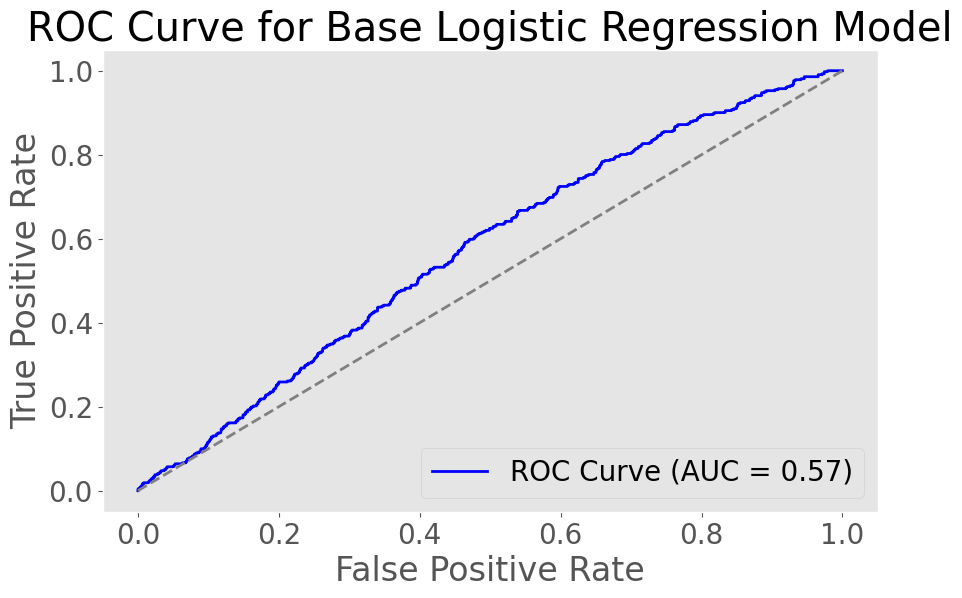

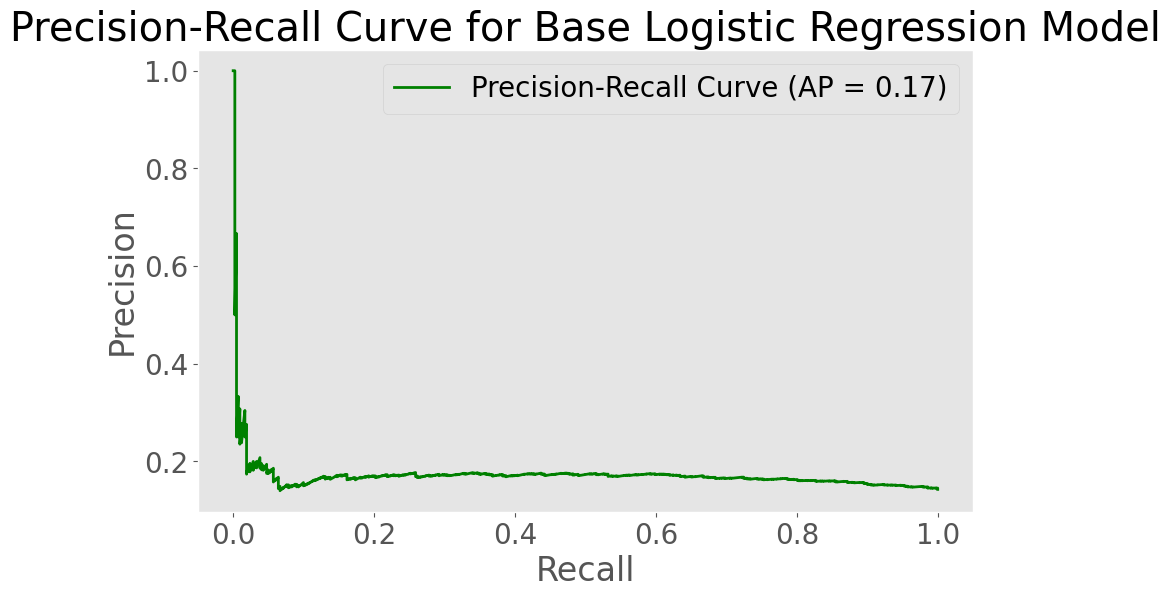

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Base Logistic Regression Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Base Logistic Regression Model')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### Tuned Logistic Regression Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import numpy as np

# Drop unnecessary columns, including ICD code which should not be a predictor
X = model_data_df.drop(columns=['subject_id', 'hadm_id', 'icd_code', 'readmission'])
y = model_data_df['readmission']

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Handle class imbalance using SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Define the Logistic Regression model with a higher max_iter
log_reg_model = LogisticRegression(max_iter=2000)

# Define the outer cross-validation loop (5 folds)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the inner cross-validation loop (3 folds)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the hyperparameters for tuning
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga', 'liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [2000]
}

# Set up the GridSearchCV for hyperparameter tuning within the inner loop
grid_search = GridSearchCV(estimator=log_reg_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=inner_cv,
                           verbose=1,
                           n_jobs=-1)

# Use cross_val_predict to make predictions for each fold during outer cross-validation
y_pred_cv = cross_val_predict(grid_search, X_balanced, y_balanced, cv=outer_cv, n_jobs=-1)

# Calculate and print the accuracy score and classification report using cross-validated predictions
print("Accuracy Score:", accuracy_score(y_balanced, y_pred_cv))
print("Cross-Validated Classification Report:\n", classification_report(y_balanced, y_pred_cv))

Accuracy Score: 0.5520155530868116
Cross-Validated Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.46     12602
           1       0.54      0.72      0.62     12602

    accuracy                           0.55     25204
   macro avg       0.56      0.55      0.54     25204
weighted avg       0.56      0.55      0.54     25204



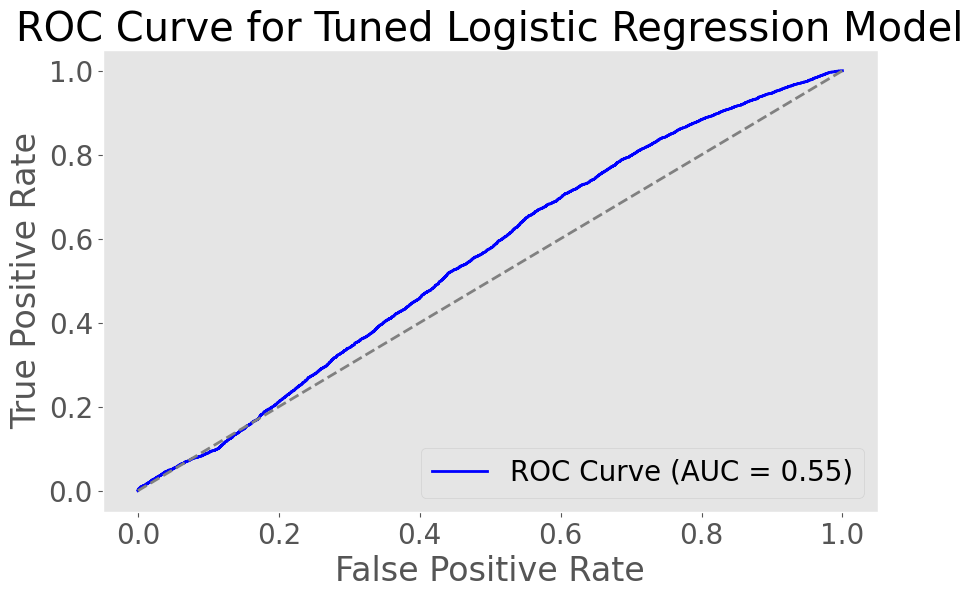

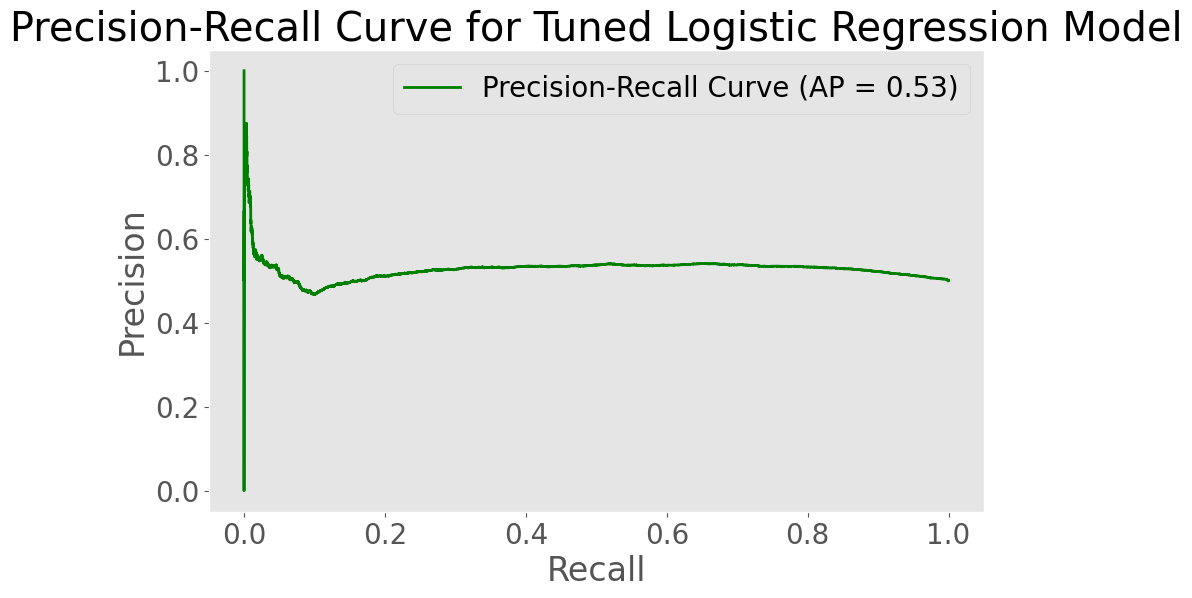

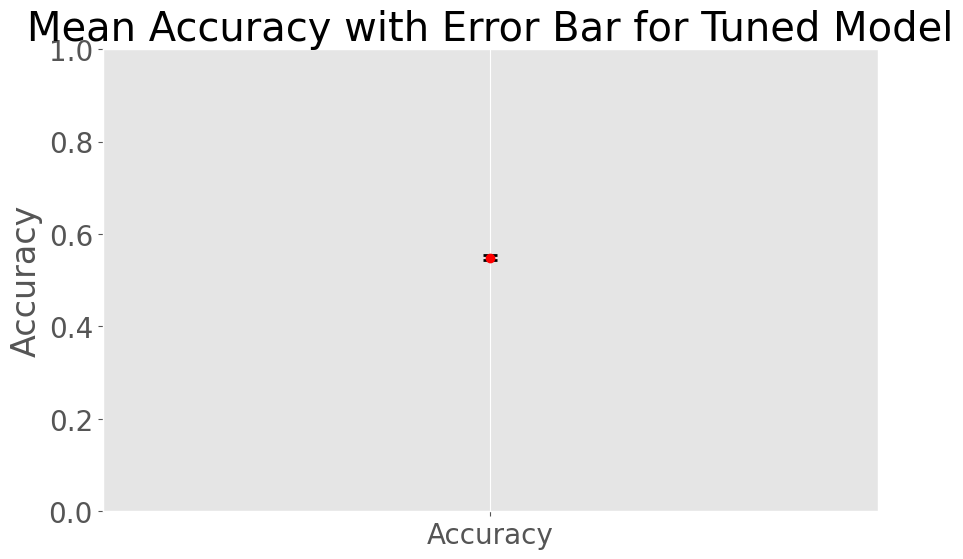

In [ ]:
# Import required metrics functions for the visuals
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Generate ROC Curve for the tuned model using balanced dataset
y_pred_proba_cv = cross_val_predict(grid_search, X_train_balanced, y_train_balanced, cv=outer_cv, method='predict_proba', n_jobs=-1)
y_pred_prob_positive = y_pred_proba_cv[:, 1]

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_train_balanced, y_pred_prob_positive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Logistic Regression Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Generate Precision-Recall Curve using balanced dataset
precision, recall, _ = precision_recall_curve(y_train_balanced, y_pred_prob_positive)
average_precision = average_precision_score(y_train_balanced, y_pred_prob_positive)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned Logistic Regression Model')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Plotting error bars for accuracy across folds using balanced dataset
nested_scores = cross_val_score(grid_search, X_train_balanced, y_train_balanced, cv=outer_cv, scoring='accuracy', n_jobs=-1)
mean_accuracy = np.mean(nested_scores)
std_accuracy = np.std(nested_scores)

plt.figure(figsize=(10, 6))
plt.errorbar(x=['Accuracy'], y=[mean_accuracy], yerr=[std_accuracy], fmt='o', color='red', ecolor='black', capsize=5, capthick=2)
plt.ylim([0, 1])
plt.title('Mean Accuracy with Error Bar for Tuned Model')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

## XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Load the dataset from the specified CSV file
data = pd.read_csv("model_data.csv")

# Drop unnecessary columns, assuming 'subject_id', 'hadm_id', and 'icd_code' should not be predictors
X = data.drop(columns=['subject_id', 'hadm_id', 'icd_code', 'readmission'])
y = data['readmission']

# Encode non-numeric (object) columns to numeric
for col in X.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])

# Fill missing values in numeric columns with the median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# # Handle class imbalance using SMOTE for oversampling the minority class
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X_imputed, y)
# Apply SMOTETomek to handle class imbalance
smote_tomek = SMOTETomek(random_state=42)
X_balanced, y_balanced = smote_tomek.fit_resample(X_imputed, y)

# Split the balanced dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Convert the training and testing data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for the XGBoost classification model
params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 3,                   # Maximum depth of each tree
    'eta': 0.01,                      # Learning rate
    'eval_metric': 'logloss',         # Log loss as evaluation metric for classification
    'subsample': 1.0,                 # Proportion of data used per iteration
    'colsample_bytree': 1.0           # Proportion of features used per tree
}

# Train the XGBoost model on the entire training data
bst = xgb.train(params, dtrain, num_boost_round=100)

# Use the trained model to predict the target variable for the test set
y_pred_prob = bst.predict(dtest)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate and print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],  # tree depth
    'eta': [0.001, 0.01, 0.1, 0.2, 0.3],  # learning rate
    'subsample': [0.6, 0.8, 1.0],  # each iterate use proportion
    'colsample_bytree': [0.8, 1.0],  # feature proportion
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

In [ ]:
# Import necessary libraries for visualization
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate ROC Curve for the XGBoost model
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost Model')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Support Vector Machine

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import uniform
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv("model_data.csv")

# Drop 'icd_code' column if it's not needed
data.drop(columns=["icd_code", "subject_id", "hadm_id"], inplace=True)

# Separate features and target variable
X = data.drop(columns=['readmission'])
y = data['readmission'].astype(int)

# Check the distribution of the target variable before imputation
print("Target variable distribution before imputation:")
print(y.value_counts())

# Handle missing values using KNN Imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the dataset
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the target variable after splitting
print("\nTarget variable distribution in training set:")
print(y_train_orig.value_counts())
print("\nTarget variable distribution in test set:")
print(y_test.value_counts())

# Under-sampling the majority class
rus = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_orig, y_train_orig)
print("\nAfter Random Under-Sampling:")
print(f"Training target statistics: {np.bincount(y_train_resampled)}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the SVM model
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Train the model
print("\nStarting Randomized Search for hyperparameter tuning...")
random_search.fit(X_train_scaled, y_train_resampled)
print("Randomized Search completed.")

# print params
print("Best hyperparameters found:")
print(random_search.best_params_)

# Evaluate the model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy on test set: {accuracy:.2f}')
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Target variable distribution before imputation:
readmission
0    12602
1     2140
Name: count, dtype: int64

Target variable distribution in training set:
readmission
0    10081
1     1712
Name: count, dtype: int64

Target variable distribution in test set:
readmission
0    2521
1     428
Name: count, dtype: int64

After Random Under-Sampling:
Training target statistics: [1712 1712]

Starting Randomized Search for hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Randomized Search completed.
Best hyperparameters found:
{'C': 0.30584494295802445, 'gamma': 'auto', 'kernel': 'rbf'}

Accuracy on test set: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.36      0.52      2521
           1       0.17      0.77      0.28       428

    accuracy                           0.42      2949
   macro avg       0.54      0.57      0.40      2949
weighted avg       0.80      0.42      0.48      2949


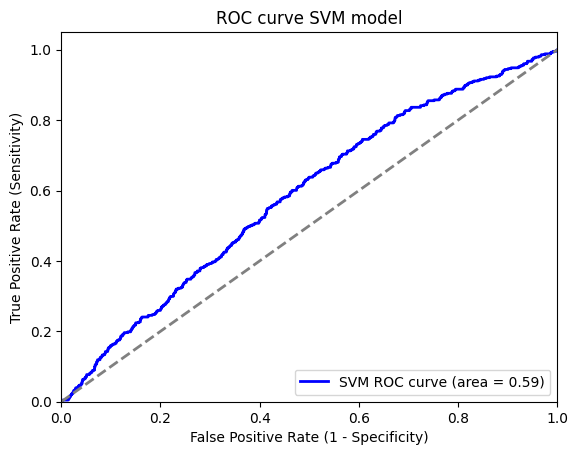

In [ ]:
from sklearn.metrics import roc_curve, auc

# Obtain decision scores from the model
y_scores = best_model.decision_function(X_test_scaled)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'SVM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve SVM model')
plt.legend(loc='lower right')
plt.show()

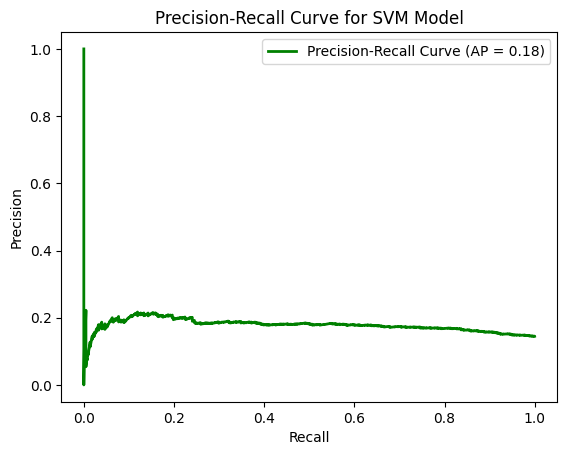

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM Model')
plt.legend(loc='upper right')
plt.show()

RANDOM FOREST MODEL

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Changed to RandomForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Prepare the data
X = model_data_df.drop(columns=['subject_id', 'hadm_id', 'icd_code', 'readmission'])
y = model_data_df['readmission']

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Maximum depth of trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance (additional benefit of Random Forest)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))

# You can also add cross-validation if needed
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

# Optional: Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importance.sort_values('importance', ascending=True).plot(
    x='feature',
    y='importance',
    kind='barh'
)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()